In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, Flatten, Dropout
from tensorflow.keras.models import Model


c:\Users\Sayantan Datta\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


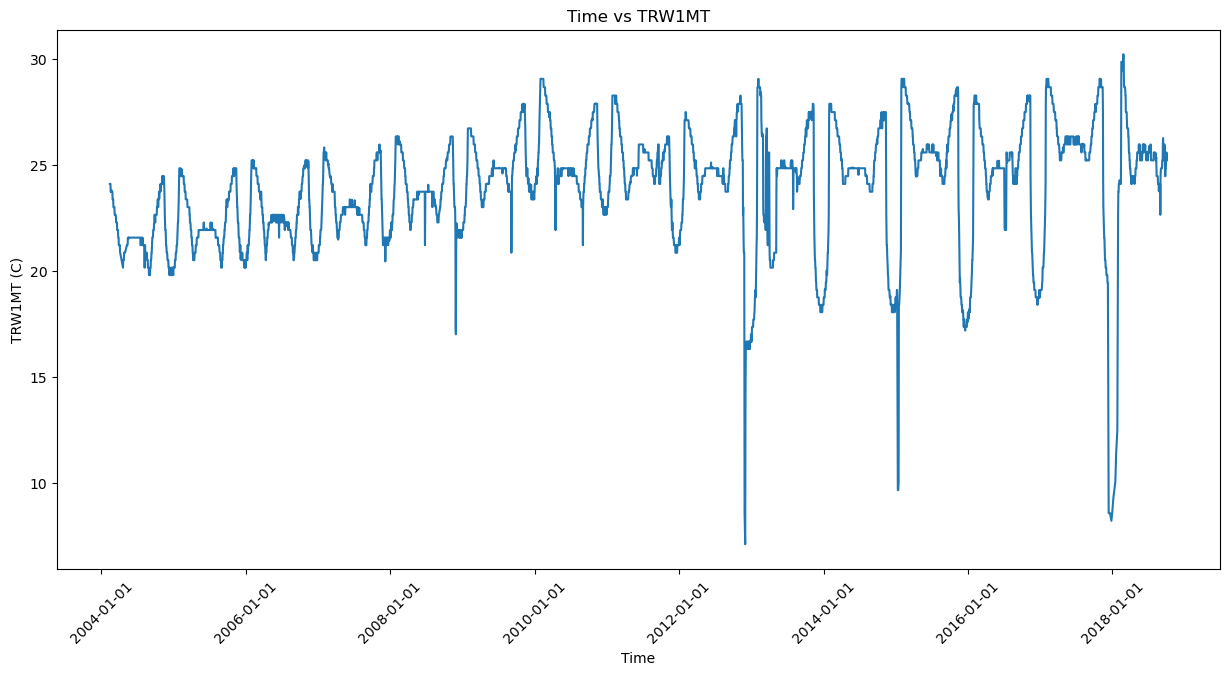

In [6]:
# load the data with 'time' parsed as datetime and set as index
TRCurrentData = pd.read_csv(r"C:\Users\Sayantan Datta\Desktop\Uni\Unsupervised ML\Final Project\Final Project Dataset\TRcurrentdata_sampled.csv", parse_dates=['time'])
TRCurrentData.set_index('time', inplace=True)

# visualize the time series data
plt.figure(figsize=(15, 7))
plt.plot(TRCurrentData.index, TRCurrentData['TRW1MT (C)'])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)
plt.xlabel('Time')
plt.ylabel('TRW1MT (C)')
plt.title('Time vs TRW1MT')
plt.show()


In [7]:
# prepare the data for model input
data = TRCurrentData['TRW1MT (C)'].values
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data.reshape(-1, 1)).flatten()

def create_sequences(data, timestamps, time_steps=1):
    xs, ys, ts = [], [], []
    for i in range(len(data) - time_steps):
        xs.append(data[i:(i + time_steps)])
        ys.append(data[i + time_steps])
        ts.append(timestamps[i])  # corresponding timestamp

    return np.array(xs), np.array(ys), np.array(ts)

time_steps = 5
X, y, time_stamps = create_sequences(data_normalized, TRCurrentData.index, time_steps)

# split the data into training and test sets and time stamps for train and test for visualizations
X_train, X_test, y_train, y_test, ts_train, ts_test = train_test_split(X, y, time_stamps, test_size=0.2, random_state=0)

# reshape data for Conv1D layer
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# define the Temporal Convolutional Network (TCN) model
inputs = Input(shape=(X_train.shape[1], 1))
x = Conv1D(filters=64, kernel_size=1, dilation_rate=1, activation='relu')(inputs)
x = Dropout(0.2)(x)
x = Flatten()(x)
outputs = Dense(1, activation='linear')(x)
model = Model(inputs, outputs)

# compile the model
model.compile(optimizer='adam', loss='mse')

In [8]:
# train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5275 - val_loss: 0.0764
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0779 - val_loss: 0.0682
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0746 - val_loss: 0.0565
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0741 - val_loss: 0.0520
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0496 - val_loss: 0.0514
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0461 - val_loss: 0.0488
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0559 - val_loss: 0.0491
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0587 - val_loss: 0.0469
Epoch 9/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0504 - val_loss: 0.0461
Epoch 10/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0383 - val_loss: 0.0473
Epoch 11/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0484 - val_loss: 0.0477
Epoch 12/100
125/125 ━━━━━━━━━━━━━━━━━━━━

In [9]:
# use the trained model to predict the test set
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test MSE: 0.04214365305916085


In [31]:
# anomaly detection threshold
#threshold = np.mean(history.history['loss']) + 2 * np.std(history.history['loss'])
#threshold = np.mean(np.abs(y_test - y_pred.flatten())) + 2 * np.std(np.abs(y_test - y_pred.flatten()))
threshold = 0.09
print(f"Anomaly detection threshold: {threshold}")

# use threshold from above to separate all the anomalies
anomalies = np.abs(y_test - y_pred.flatten()) > threshold

# reverse the normalization to the test
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_test_prediction = scaler.inverse_transform(y_pred).flatten()

anomalies_df = pd.DataFrame({
    'Time': ts_test,
    'Actual': y_test_original,
    'Predicted': y_test_prediction,
    'Error': np.abs(y_test - y_pred.flatten()),
    'Anomaly': anomalies
})

Anomaly detection threshold: 0.09


In [32]:
anomalies_df.head()

,Time,Actual,Predicted,Error,Anomaly
0,2017-11-26 10:17:30,19.816489,20.106836,0.112261,True
1,2010-04-26 20:07:30,24.118417,24.048008,0.027223,False
2,2006-02-28 02:02:30,24.118417,24.096865,0.008333,False
3,2012-06-07 16:32:30,24.857049,24.870810,0.005321,False
4,2009-10-27 16:27:30,27.528587,27.751478,0.086179,False


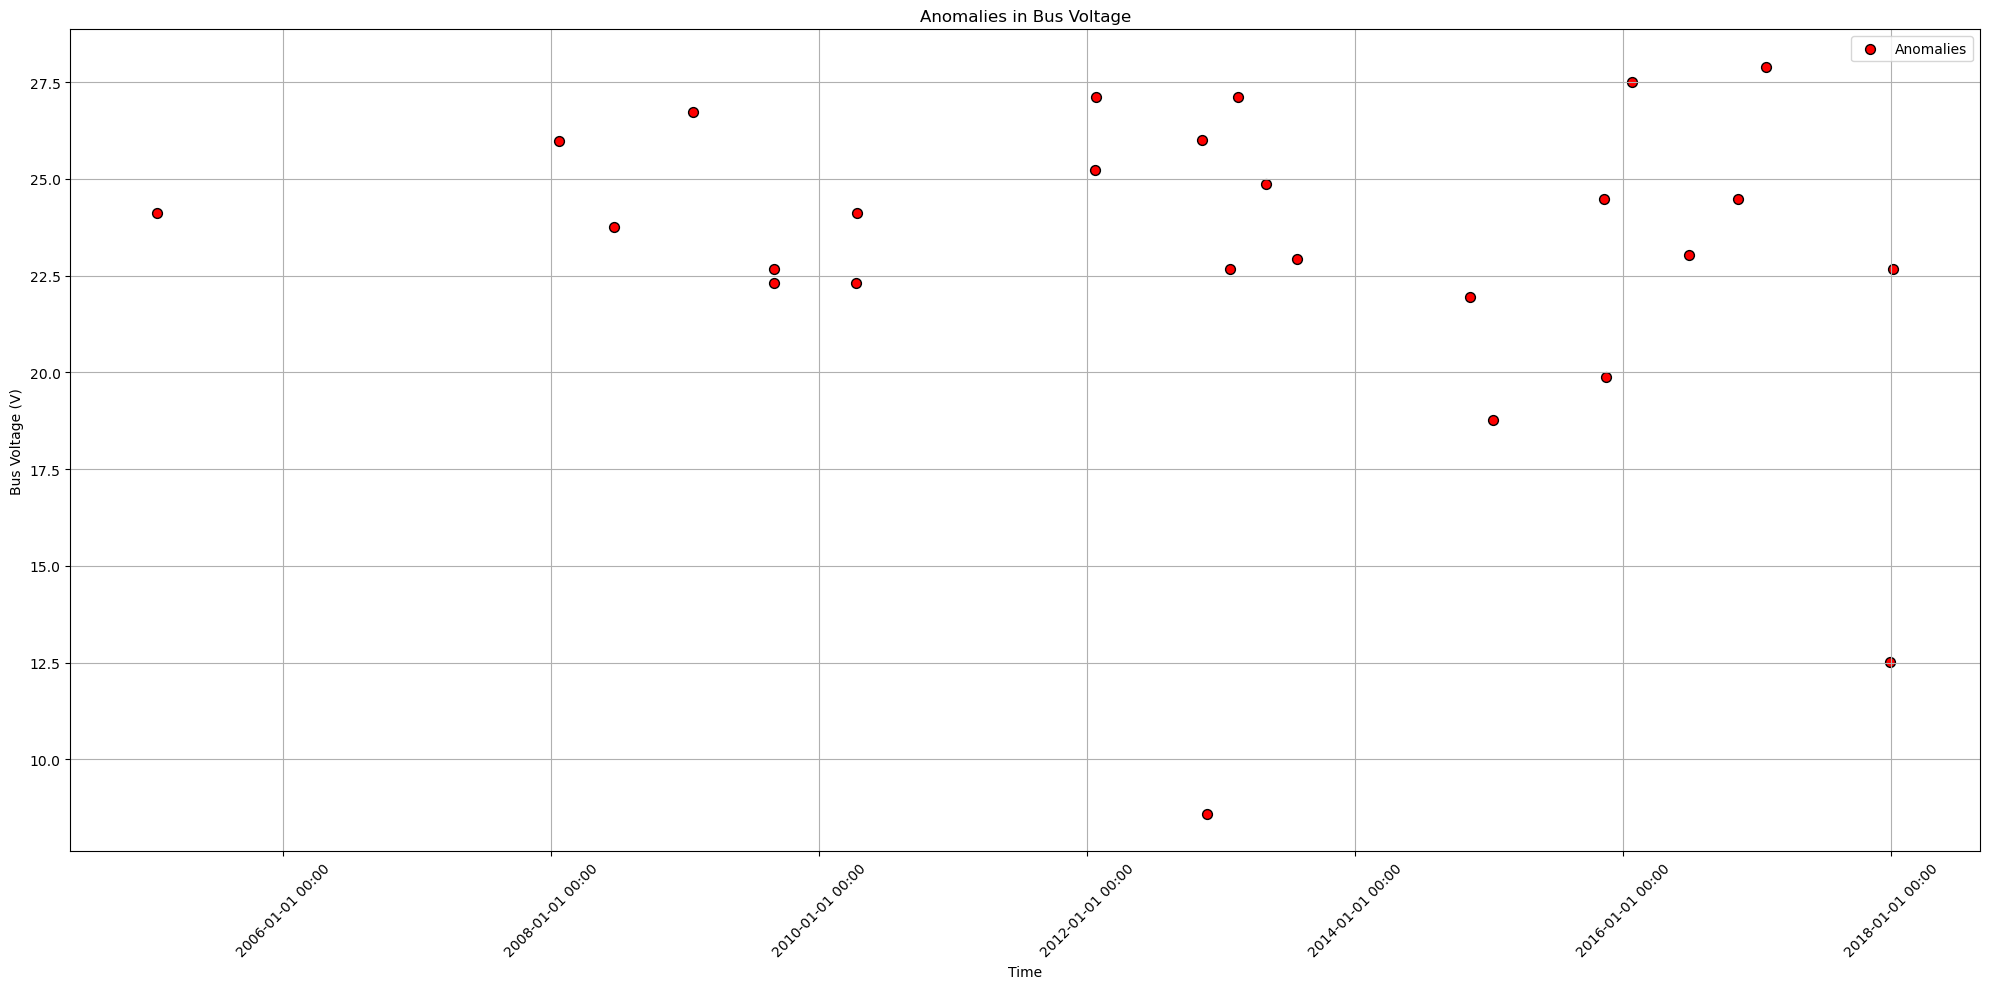

In [23]:
# plotting anomalies
plt.figure(figsize=(20, 10))

# coonvert 'Time' from numpy.datetime64 to datetime for plotting
anomalies_df['Time'] = pd.to_datetime(anomalies_df['Time'])

# highlighting anomalies with red scatter plots
anomalies_present = anomalies_df[anomalies_df['Anomaly'] == True]
plt.scatter(anomalies_present['Time'], anomalies_present['Actual'], color='red', label='Anomalies', s=50, edgecolors='black')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)
plt.xlabel('Time')
plt.ylabel('Bus Voltage (V)')
plt.title('Anomalies in Bus Voltage')
plt.legend()
plt.grid(True)
plt.tight_layout()  

plt.show()


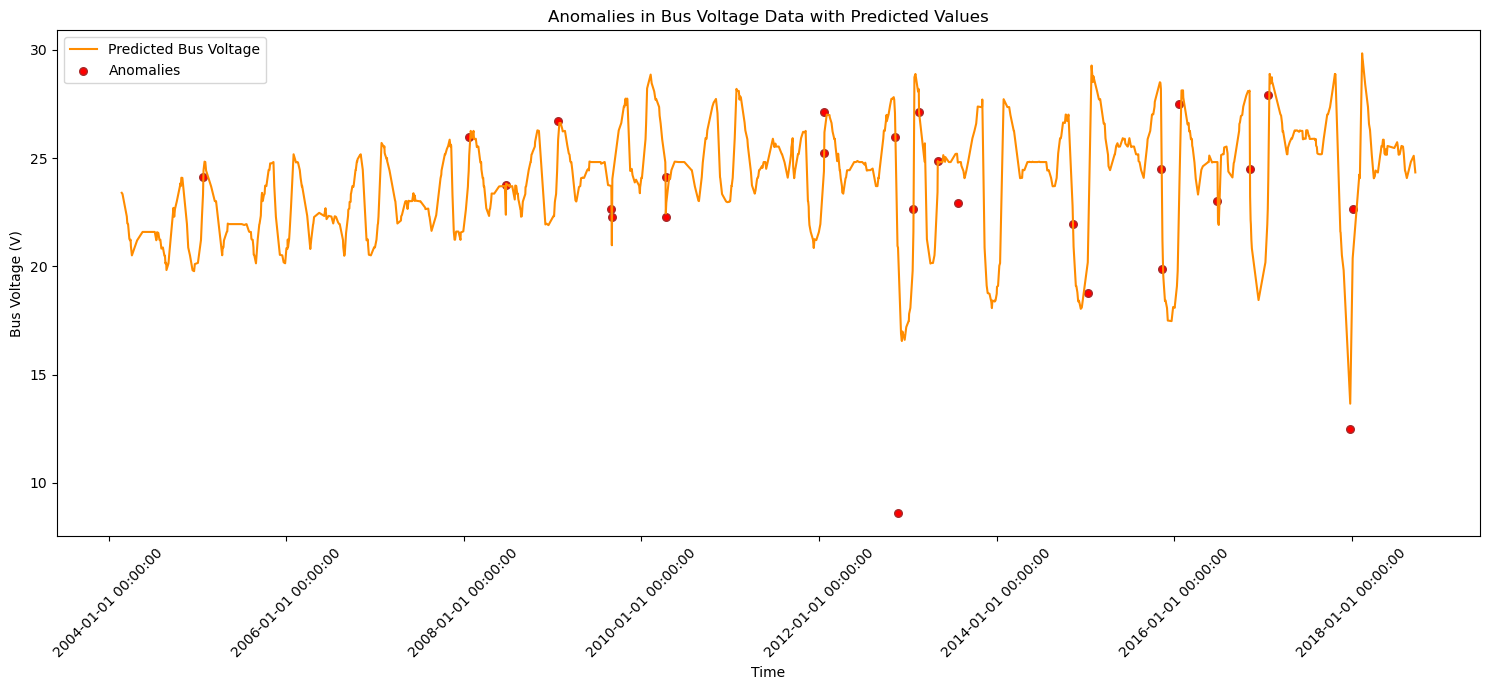

In [24]:
ts_test_datetime = pd.to_datetime(ts_test)

# sort ts_test_datetime, y_test, and y_pred arrays according to the timestamps
sorted_indices = np.argsort(ts_test_datetime)
sorted_test_time_steps = np.array(ts_test_datetime)[sorted_indices]
sorted_y_test_original = y_test_original[sorted_indices]
sorted_y_pred_original = y_test_prediction[sorted_indices]

sorted_anomalies = anomalies[sorted_indices]

plt.figure(figsize=(15, 7))

# # plot the sorted actual values
# plt.plot(sorted_test_time_steps, sorted_y_test_original, label='Actual Bus Voltage', color='dodgerblue')

# plot the sorted predicted values
plt.plot(sorted_test_time_steps, sorted_y_pred_original, label='Predicted Bus Voltage', color='darkorange')

plt.scatter(sorted_test_time_steps[sorted_anomalies], sorted_y_test_original[sorted_anomalies], color='red', label='Anomalies', s=30, edgecolor='brown')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)
plt.xlabel('Time')
plt.ylabel('Bus Voltage (V)')
plt.title('Anomalies in Bus Voltage Data with Predicted Values')
plt.legend()
plt.tight_layout()
plt.show()


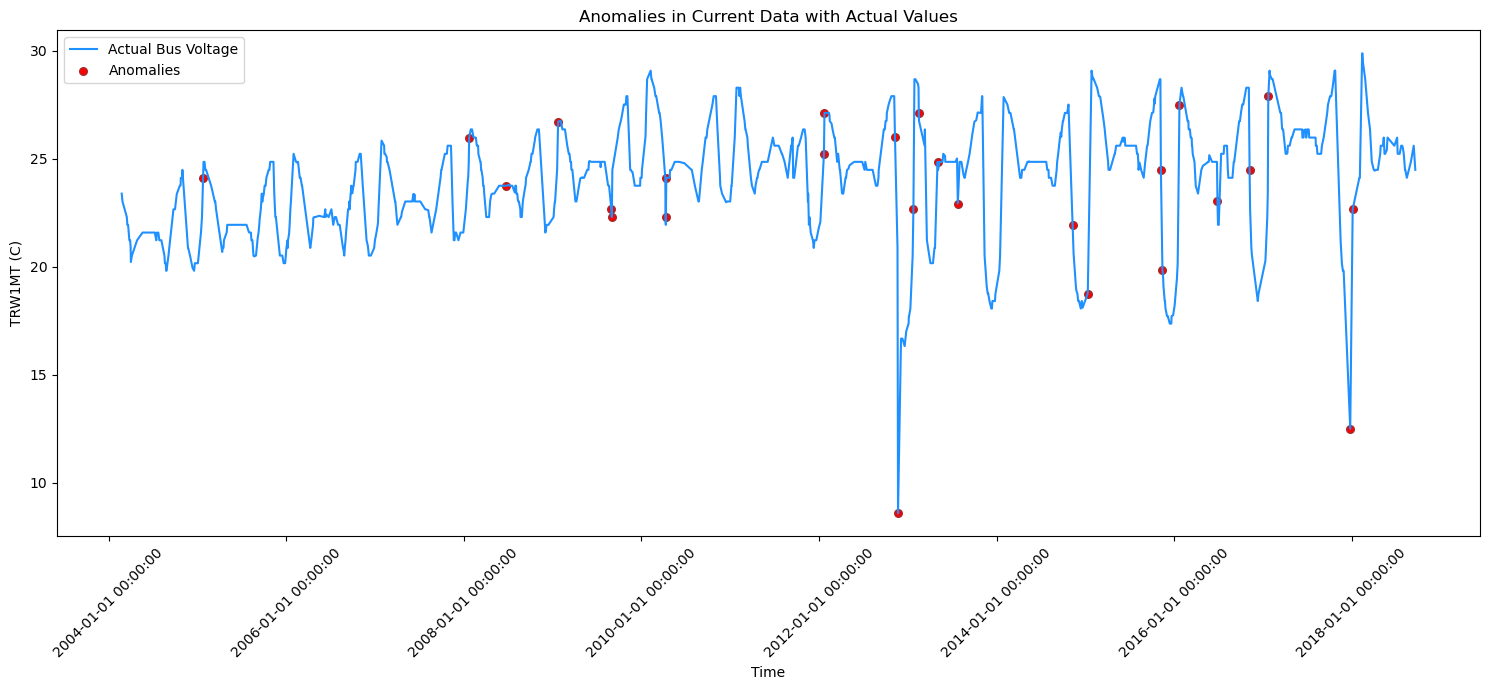

In [33]:
plt.figure(figsize=(15, 7))

# plot the sorted actual values
plt.plot(sorted_test_time_steps, sorted_y_test_original, label='Actual Bus Voltage', color='dodgerblue')

# # plot the sorted predicted values
# plt.plot(sorted_test_time_steps, sorted_y_pred_original, label='Predicted Bus Voltage', color='darkorange')

plt.scatter(sorted_test_time_steps[sorted_anomalies], sorted_y_test_original[sorted_anomalies], color='red', label='Anomalies', s=30, edgecolor='brown')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)
plt.xlabel('Time')
plt.ylabel('TRW1MT (C)')
plt.title('Anomalies in Current Data with Actual Values')
plt.legend()
plt.tight_layout()
plt.show()
